<a href="https://colab.research.google.com/github/adenurchalisa/Capstone-Model/blob/main/model_prediksi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt

In [ ]:
# 1. Mount Google Drive (jika di Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

file_path = '/content/drive/MyDrive/capstoneku/data_transaksi_advanced.csv'
df = pd.read_csv(file_path)
df['tanggal'] = pd.to_datetime(df['tanggal'])

In [ ]:

df = df.drop(columns=['rating', 'anomaly_flag', 'id_transaksi'])
df['bulan'] = df['tanggal'].dt.month
df['tahun'] = df['tanggal'].dt.year
df['hari'] = df['tanggal'].dt.day
df['hari_ke'] = df['tanggal'].dt.dayofweek
df['jam'] = pd.to_datetime(df['waktu'], format='%H:%M').dt.hour
df = df.drop(columns=['tanggal', 'waktu'])

In [10]:
# Fitur musiman/event
df['is_ramadan'] = (
    ((df['tahun'] == 2022) & (df['bulan'] == 4)) |
    ((df['tahun'] == 2023) & (df['bulan'].isin([3, 4]))) |
    ((df['tahun'] == 2024) & (df['bulan'].isin([3, 4])))
).astype(int)

df['is_lebaran'] = (
    ((df['tahun'] == 2022) & (df['bulan'] == 5)) |
    ((df['tahun'] == 2023) & (df['bulan'] == 4)) |
    ((df['tahun'] == 2024) & (df['bulan'] == 4))
).astype(int)

df['is_libur_sekolah'] = df['bulan'].isin([6, 7]).astype(int)
df['is_akhir_tahun'] = (df['bulan'] == 12).astype(int)

In [12]:
le_profil = LabelEncoder()
df['profil_enc'] = le_profil.fit_transform(df['profil'])
le_mp = LabelEncoder()
df['metode_pembayaran_enc'] = le_mp.fit_transform(df['metode_pembayaran'])
le_lokasi = LabelEncoder()
df['lokasi_enc'] = le_lokasi.fit_transform(df['lokasi'])

In [13]:

df_pengeluaran = df[df['tipe'] == 'keluar'].copy()

In [21]:
agg = df_pengeluaran.groupby(['user_id', 'tahun', 'bulan']).agg(
    total_pengeluaran=('nominal', 'sum'),
    jumlah_transaksi=('nominal', 'count'),
    rata2_transaksi=('nominal', 'mean'),
    profil_enc=('profil_enc', 'first'),
    metode_pembayaran_enc=('metode_pembayaran_enc', lambda x: x.mode()[0] if len(x) else 0),
    lokasi_enc=('lokasi_enc', lambda x: x.mode()[0] if len(x) else 0)
).reset_index()

agg = agg.sort_values(['user_id', 'tahun', 'bulan'])

In [22]:
agg['pengeluaran_bulan_lalu'] = agg.groupby('user_id')['total_pengeluaran'].shift(1)
agg['rolling3_pengeluaran'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).mean().shift(1).values
agg['rolling3_std'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).std().shift(1).values
agg['rolling3_min'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).min().shift(1).values
agg['rolling3_max'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).max().shift(1).values
agg['trend_bulan'] = (agg['total_pengeluaran'] - agg['pengeluaran_bulan_lalu']) / (agg['pengeluaran_bulan_lalu'] + 1)
agg['target'] = agg.groupby('user_id')['total_pengeluaran'].shift(-1)

In [23]:
# Ramadan
agg['is_ramadan'] = (
    ((agg['tahun'] == 2022) & (agg['bulan'] == 4)) |
    ((agg['tahun'] == 2023) & (agg['bulan'].isin([3, 4]))) |
    ((agg['tahun'] == 2024) & (agg['bulan'].isin([3, 4])))
).astype(int)
# Lebaran
agg['is_lebaran'] = (
    ((agg['tahun'] == 2022) & (agg['bulan'] == 5)) |
    ((agg['tahun'] == 2023) & (agg['bulan'] == 4)) |
    ((agg['tahun'] == 2024) & (agg['bulan'] == 4))
).astype(int)
# Libur sekolah
agg['is_libur_sekolah'] = agg['bulan'].isin([6, 7]).astype(int)
# Akhir tahun
agg['is_akhir_tahun'] = (agg['bulan'] == 12).astype(int)

In [24]:

agg = agg.dropna(subset=['target', 'pengeluaran_bulan_lalu', 'rolling3_pengeluaran', 'rolling3_std', 'rolling3_min', 'rolling3_max', 'trend_bulan']).reset_index(drop=True)

In [25]:
train = agg[agg['tahun'] < 2024]
test = agg[agg['tahun'] == 2024]

fitur = [
    'total_pengeluaran', 'jumlah_transaksi', 'rata2_transaksi',
    'profil_enc', 'metode_pembayaran_enc', 'lokasi_enc', 'bulan',
    'pengeluaran_bulan_lalu', 'rolling3_pengeluaran',
    'rolling3_std', 'rolling3_min', 'rolling3_max', 'trend_bulan',
    # Tambahkan fitur musiman/event di bawah ini
    'is_ramadan', 'is_lebaran', 'is_libur_sekolah', 'is_akhir_tahun'
]

X_train = train[fitur]
y_train = train['target']
X_test = test[fitur]
y_test = test['target']

In [26]:

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [27]:
# 2. Define parameter grid
param_grid = {
    'n_estimators': [80, 100, 120, 140, 160],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.08, 0.1, 0.12, 0.15],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [3, 5, 7, 10],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

xgb_base = XGBRegressor(random_state=42, n_jobs=-1)

In [28]:
# 3. TimeSeriesSplit untuk validasi yang adil pada data deret waktu
tscv = TimeSeriesSplit(n_splits=3)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=60,  # diperbanyak supaya eksplorasi parameter lebih dalam
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [29]:
# 4. Tuning pada data training (pakai target log)
random_search.fit(X_train, y_train_log)

print("Best parameters found:")
print(random_search.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best parameters found:
{'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.12, 'gamma': 7, 'colsample_bytree': 0.9}


In [30]:
# 5. Evaluasi pada data test
best_model = random_search.best_estimator_
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

mask = y_test > 200000
if mask.sum() > 0:
    mape_200k = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
    print(f"MAPE (target > 200k): {mape_200k:.2f}%")
else:
    print("Tidak ada data target > 200 ribu.")

MAE: 5940091.78
RMSE: 10220430.87
MAPE: 391.71%
MAPE (target > 200k): 146.76%


In [31]:
# 6. Baseline untuk perbandingan
baseline_pred = X_test['pengeluaran_bulan_lalu']
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_mape = np.mean(np.abs((y_test - baseline_pred) / y_test)) * 100
print(f"Baseline MAE: {baseline_mae:.2f}, Baseline MAPE: {baseline_mape:.2f}%")

Baseline MAE: 8093284.09, Baseline MAPE: 674.36%


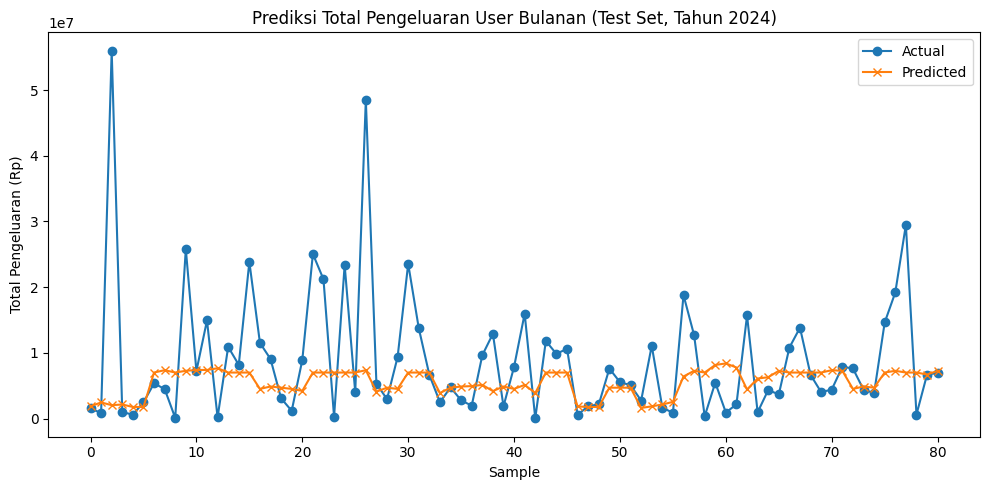

In [32]:
# 7. Visualisasi (opsional, sama seperti sebelumnya)
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title('Prediksi Total Pengeluaran User Bulanan (Test Set, Tahun 2024)')
plt.xlabel('Sample')
plt.ylabel('Total Pengeluaran (Rp)')
plt.tight_layout()
plt.show()